In [1]:
#@title Task 2 start.

In [2]:

#@title Step 1: Import all necessary libraries (ok).
# General python library (ok).
import os
import cv2
import numpy as np
from PIL import Image, ImageEnhance
from matplotlib import pyplot as plt
import matplotlib.animation as animation
import time

# Torch library (ok).
import torch
from torch.utils.data import Dataset
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch import nn
from torchvision import datasets, transforms as tfs
import torch.nn.init as init
import torch.nn.functional as F


In [3]:
#@title Step 2: Define utility functions (ok).
# Define training function (ok).
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

# Define error_performance function (ok).
def error_performance(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    if dataloader.dataset.train == True: print(f"----> Train accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}!")
    else: print(f"----> Test accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}!")
    return 100*correct

In [4]:
#@title Start of task 2.

In [5]:
#@title Step 1: Load and transform the MNIST dataset (ok).
sigma = 40 #@param
def transform_data(dt):
    data_list = []
    label_list = []
    def resize_tensor(tensor, desired_size = (32, 32)):
        resized_tensor = nn.functional.interpolate(tensor.unsqueeze(0).unsqueeze(0), size=desired_size, mode='bilinear', align_corners=False)
        return resized_tensor.squeeze(0).squeeze(0)
    for i in range(len(dt.data)):
        temp = resize_tensor(dt.data[i]).float()
        label_list += [temp.unsqueeze(0)]
        data_list += [torch.clamp(temp + sigma * torch.randn(temp.shape[0], temp.shape[1]), 0, 255).unsqueeze(0)]
    return torch.stack(data_list), torch.stack(label_list)

data_transform_basic = tfs.Compose([
    tfs.ToTensor(),
])

training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=data_transform_basic
)

training_data_list, training_label_list = transform_data(training_data)
training_data_2 = TensorDataset(training_data_list, training_label_list)

testing_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=data_transform_basic
)
testing_data_list, testing_label_list = transform_data(testing_data)
testing_data_2 = TensorDataset(testing_data_list, testing_label_list)

# Create data loaders.
batch_size = 64
training_dataloader_2 = DataLoader(training_data_2, batch_size=batch_size)
testing_dataloader_2 = DataLoader(testing_data_2, batch_size=batch_size)

100%|██████████| 9912422/9912422 [00:00<00:00, 263369111.08it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 55822900.38it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 66682975.10it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 21027073.70it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [6]:
#@title Testing block (ok).
for batch in training_dataloader_2:
    data, labels = batch
    # Perform your operations with the data and labels
    print('Data batch:', data.shape, data.dtype)
    print('Label batch:', labels.shape, labels.dtype)
    print('---')
    break

Data batch: torch.Size([64, 1, 32, 32]) torch.float32
Label batch: torch.Size([64, 1, 32, 32]) torch.float32
---


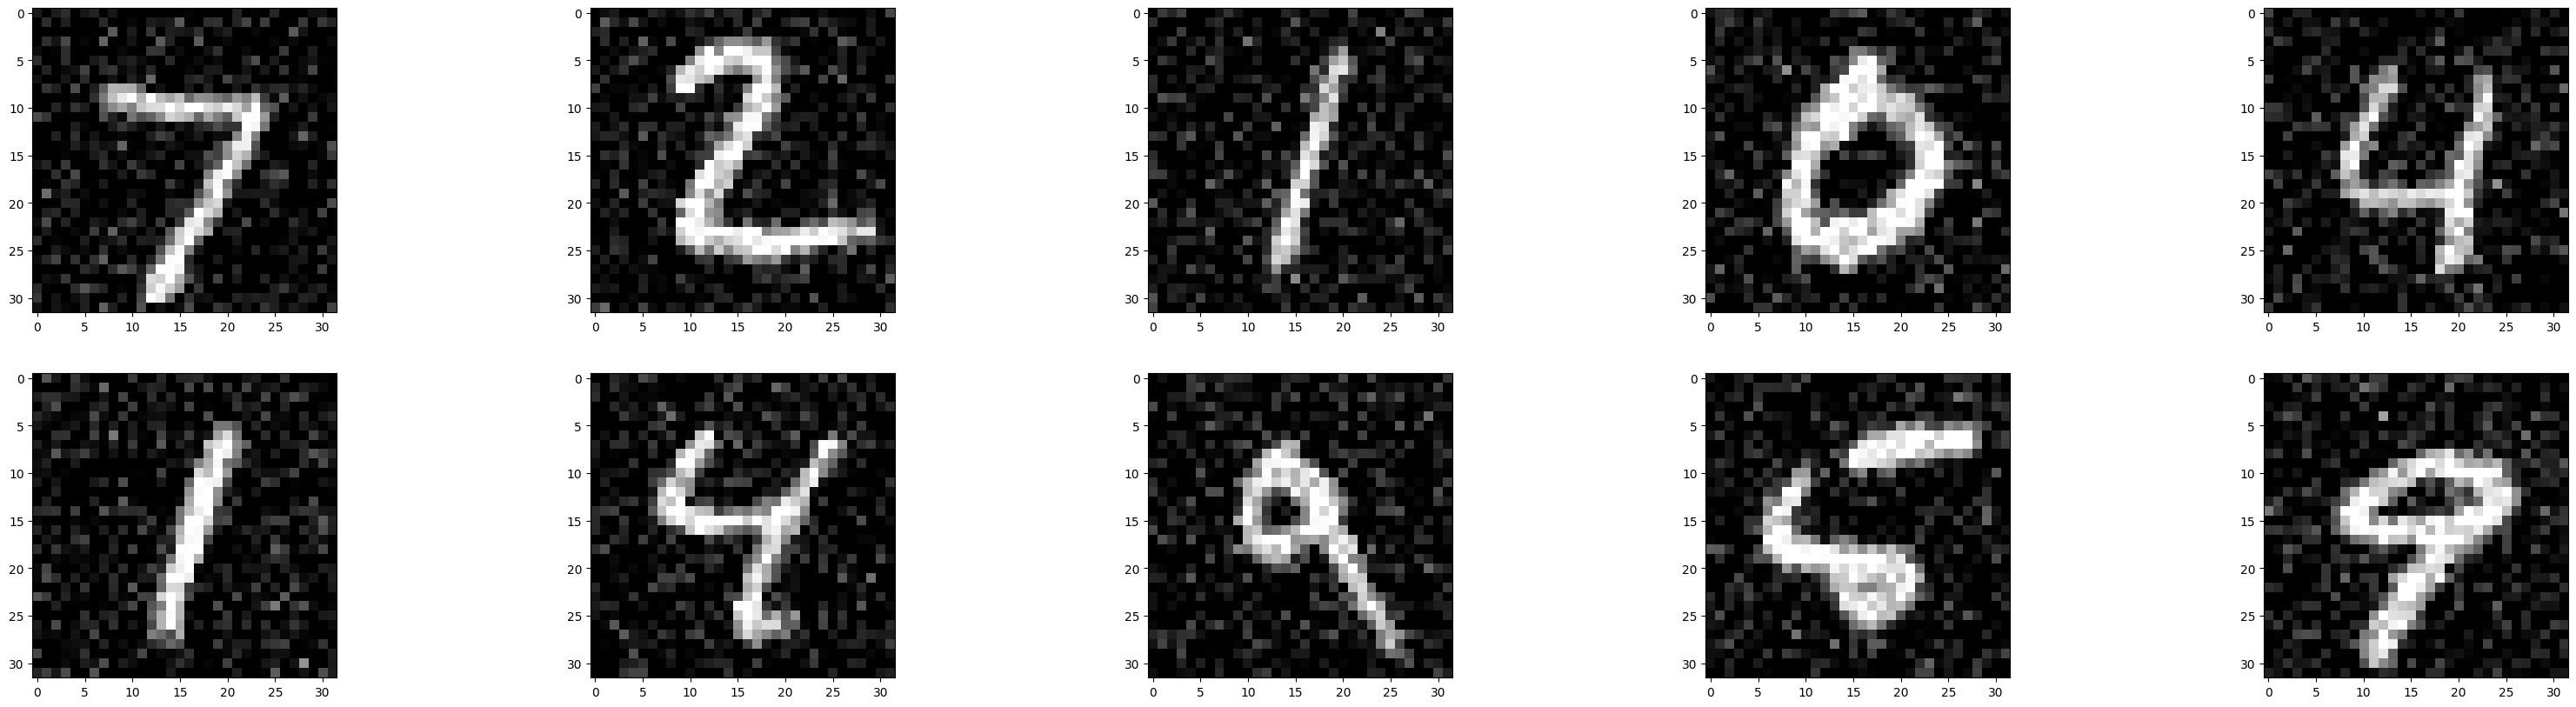

In [7]:
#@title Testing block (ok).
n = 10
plt.figure(figsize=(40, n))
for input_image, ground_truth_label in testing_dataloader_2:
    for i in range(n):
        plt.subplot(int(n/5), 5, i + 1)
        plt.imshow(input_image[i,0,...], cmap='gray')  # Display the image with three channels
    break

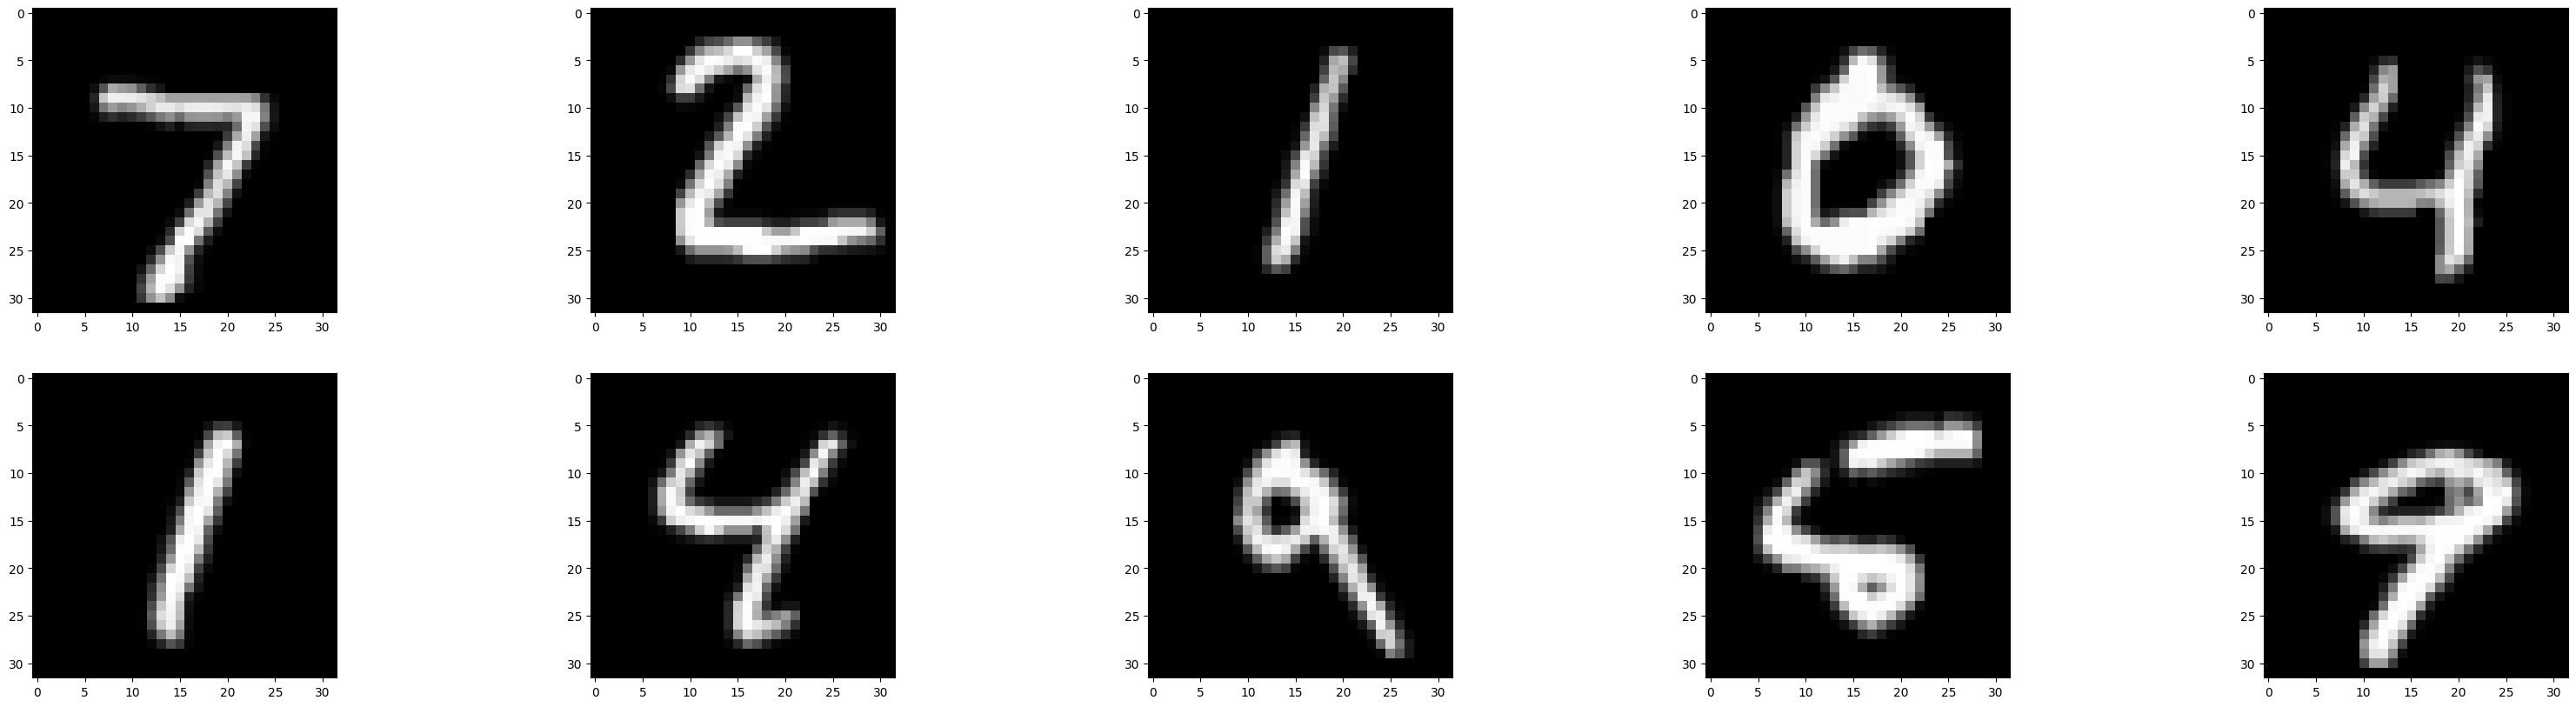

In [8]:
#@title Testing block (ok).
n = 10
plt.figure(figsize=(40, n))
for input_image, ground_truth_label in testing_dataloader_2:
    for i in range(n):
        plt.subplot(int(n/5), 5, i + 1)
        plt.imshow(ground_truth_label[i,0,...], cmap='gray')  # Display the image with three channels
    break

In [9]:
#@title Step 2: Define unet structure (ok).
# Step 2.1: Define essential parameters.
model_save_path = 'unet_model_2.pt'
device = torch.device("cuda")

# Step 2.2: Define model structure
class two_conv_relu(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_op = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv_op(x)


class down_sample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = two_conv_relu(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        down = self.conv(x)
        p = self.pool(down)

        return down, p


class up_sample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
        self.conv = two_conv_relu(in_channels, out_channels)

    def forward(self, x1, x2):
       x1 = self.up(x1)
       x = torch.cat([x1, x2], 1)
       return self.conv(x)

class Lecture_Slide_U_Net(nn.Module):
    def __init__(self, in_channels, num_classes, lrate = 3e-4, epochs = 2, loss_fn_choice = None, optimizer_choice = None):
        super().__init__()
        self.down_conv_1 = down_sample(in_channels, 64)
        self.down_conv_2 = down_sample(64, 128)
        self.down_conv_3 = down_sample(128, 256)
        self.down_conv_4 = down_sample(256, 512)

        self.bottle_neck = two_conv_relu(512, 1024)

        self.up_conv_1 = up_sample(1024, 512)
        self.up_conv_2 = up_sample(512, 256)
        self.up_conv_3 = up_sample(256, 128)
        self.up_conv_4 = up_sample(128, 64)

        self.out = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=1)

        self.lrate = lrate
        self.epochs = epochs
        self.loss_fn = nn.MSELoss() if loss_fn_choice == None else loss_fn_choice
        self.optimizer = torch.optim.AdamW(self.parameters(), self.lrate) if optimizer_choice == None else optimizer_choice

    def forward(self, x):
       down_1, p1 = self.down_conv_1(x)
       down_2, p2 = self.down_conv_2(p1)
       down_3, p3 = self.down_conv_3(p2)
       down_4, p4 = self.down_conv_4(p3)

       up_1 = self.up_conv_1(self.bottle_neck(p4), down_4)
       up_2 = self.up_conv_2(up_1, down_3)
       up_3 = self.up_conv_3(up_2, down_2)
       up_4 = self.up_conv_4(up_3, down_1)

       out = self.out(up_4)
       return out

    def load_params(self, load_path=None, device=None):
        if load_path is not None:
            try:
                self.load_state_dict(torch.load(load_path, map_location=device))
                print("Model parameters loaded successfully.")
            except Exception as e: print("Failed to load model parameters.")


    def save_params(self, save_path):
        try:
            torch.save(self.state_dict(), save_path)
            print("Model parameters saved successfully.")
        except Exception as e: print("Failed to save model parameters.")

In [10]:
#@title Testing block (ok).
input_image = torch.rand((64,1,32,32))
model_1 = Lecture_Slide_U_Net(1, 1)
output = model_1(input_image)
print(output.size())

torch.Size([64, 1, 32, 32])


In [11]:
#@title Step 3: Run the unet model with 2 epochs (ok).

# Define and train models.
unet_model_1 = Lecture_Slide_U_Net(in_channels=1, num_classes=1).to(device)
for t in range(unet_model_1.epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(training_dataloader_2, unet_model_1, unet_model_1.loss_fn, unet_model_1.optimizer)
    print("\n")

unet_model_1.save_params(model_save_path)
print("Done!")

Epoch 1
-------------------------------
loss: 6289.019531  [   64/60000]
loss: 175.020447  [ 6464/60000]
loss: 116.363373  [12864/60000]
loss: 118.842537  [19264/60000]
loss: 102.539246  [25664/60000]
loss: 104.173683  [32064/60000]
loss: 97.081413  [38464/60000]
loss: 102.225616  [44864/60000]
loss: 91.031303  [51264/60000]
loss: 86.800224  [57664/60000]


Epoch 2
-------------------------------
loss: 87.160934  [   64/60000]
loss: 84.149017  [ 6464/60000]
loss: 85.184387  [12864/60000]
loss: 88.071243  [19264/60000]
loss: 83.401520  [25664/60000]
loss: 87.993912  [32064/60000]
loss: 77.528610  [38464/60000]
loss: 81.114487  [44864/60000]
loss: 75.816910  [51264/60000]
loss: 74.435226  [57664/60000]


Model parameters saved successfully.
Done!


In [12]:
# Step 3.5: ...
unet_model_2 = Lecture_Slide_U_Net(in_channels=1, num_classes=1).to(device)
unet_model_2.load_params(model_save_path, device)
unet_model_2.eval()

Model parameters loaded successfully.


Lecture_Slide_U_Net(
  (down_conv_1): down_sample(
    (conv): two_conv_relu(
      (conv_op): Sequential(
        (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
      )
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (down_conv_2): down_sample(
    (conv): two_conv_relu(
      (conv_op): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
      )
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (down_conv_3): down_sample(
    (conv): two_conv_relu(
      (conv_op): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), 

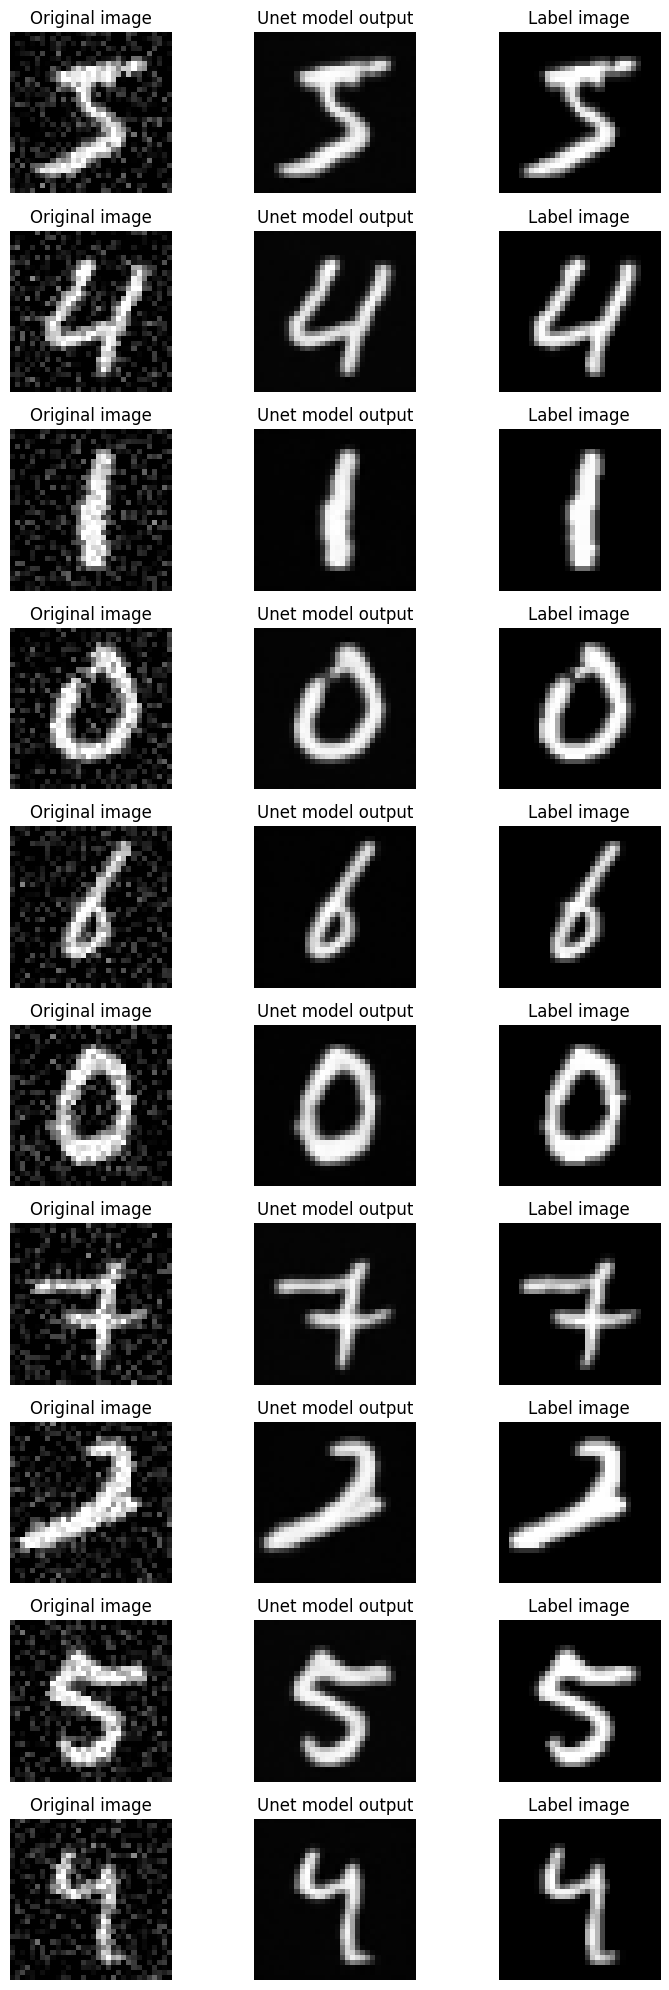

In [13]:
#@title Step 4: Visualize training result (ok).

fig, axs = plt.subplots(10, 3, figsize=(8, 20))

for i, batch in enumerate(training_dataloader_2):
    if i >= 10:
        break

    data, labels = batch

    # Perform your operations with the data and labels
    # print('Data batch:', data.shape, data.dtype)
    # print('Label batch:', labels.shape, labels.dtype)
    data = data.to(device)

    output = unet_model_2(data)

    image_output = output[0, 0].detach().cpu().numpy()
    image_data = data[0, 0].detach().cpu().numpy()
    label_data = labels[0, 0].detach().cpu().numpy()
    # print(torch.sum(torch.sqrt((torch.from_numpy(label_data) - torch.from_numpy(image_output))**2)).item())

    # Plotting the images
    axs[i, 1].imshow(image_output, cmap='gray')
    axs[i, 1].axis('off')
    axs[i, 1].set_title('Unet model output')

    axs[i, 0].imshow(image_data, cmap='gray')
    axs[i, 0].axis('off')
    axs[i, 0].set_title('Original image')

    axs[i, 2].imshow(label_data, cmap='gray')
    axs[i, 2].axis('off')
    axs[i, 2].set_title('Label image')

plt.tight_layout()
plt.show()

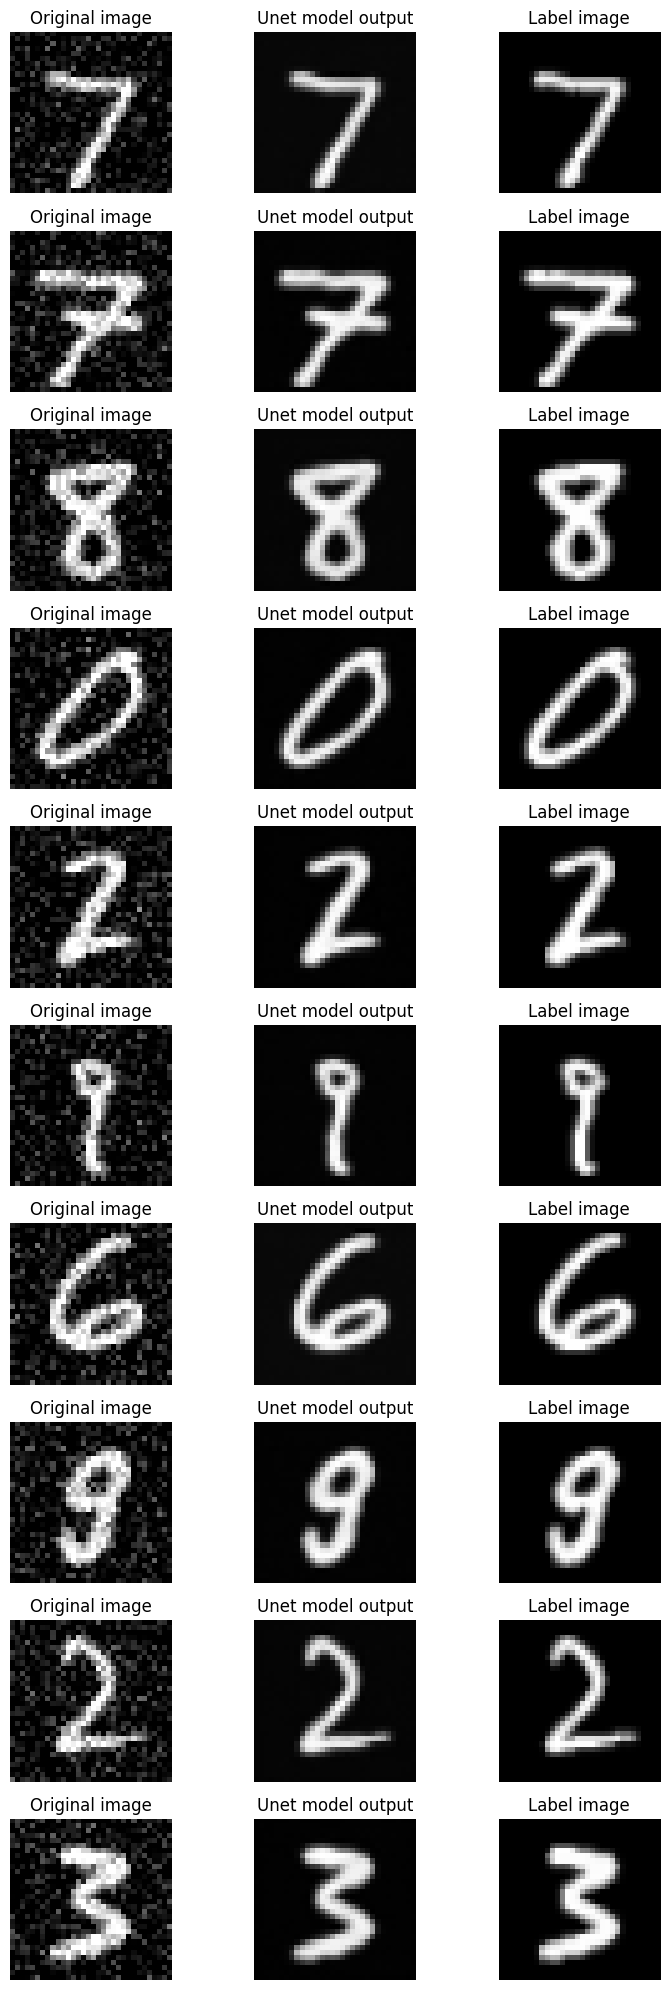

In [14]:
#@title Step 5: Visualize testing result (ok).

fig, axs = plt.subplots(10, 3, figsize=(8, 20))

for i, batch in enumerate(testing_dataloader_2):
    if i >= 10:
        break

    data, labels = batch

    # Perform your operations with the data and labels
    # print('Data batch:', data.shape, data.dtype)
    # print('Label batch:', labels.shape, labels.dtype)
    data = data.to(device)

    output = unet_model_2(data)

    image_output = output[0, 0].detach().cpu().numpy()
    image_data = data[0, 0].detach().cpu().numpy()
    label_data = labels[0, 0].detach().cpu().numpy()
    # print(torch.sum(torch.sqrt((torch.from_numpy(label_data) - torch.from_numpy(image_output))**2)).item())

    # Plotting the images
    axs[i, 1].imshow(image_output, cmap='gray')
    axs[i, 1].axis('off')
    axs[i, 1].set_title('Unet model output')

    axs[i, 0].imshow(image_data, cmap='gray')
    axs[i, 0].axis('off')
    axs[i, 0].set_title('Original image')

    axs[i, 2].imshow(label_data, cmap='gray')
    axs[i, 2].axis('off')
    axs[i, 2].set_title('Label image')

plt.tight_layout()
plt.show()

In [15]:
#@title Step 6: Try the model on other images (ok).
def png_to_tensor(image_path):
    # Open the PNG image using PIL
    image = Image.open(image_path).convert('L')  # Convert to grayscale

    # Resize the image to 32x32 pixels
    resize_transform = tfs.Resize((32, 32))
    image = resize_transform(image)

    # Increase contrast of the image
    enhancer = ImageEnhance.Contrast(image)
    image = enhancer.enhance(2.0)  # Increase contrast by a factor of 2

    # Convert the image to a tensor without normalization
    transform = tfs.ToTensor()
    tensor = transform(image).unsqueeze(0)

    # Scale the tensor values to the range of 0-255
    tensor = tensor * 255.0

    # Convert the tensor to integer type
    tensor = tensor.to(torch.float32).to(device)

    # Check tensor size
    print(tensor.shape)
    return tensor

def show_image(image):
    image_np = image.squeeze().detach().cpu().numpy()

    # Plot the image
    plt.imshow(image_np, cmap='gray', vmin=0, vmax=255)
    plt.axis('off')
    plt.show()

torch.Size([1, 1, 32, 32])


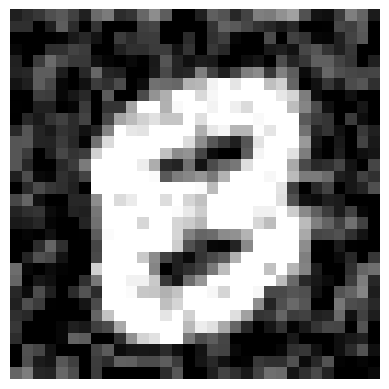

In [16]:
#@title Step 7: Show the raw image (ok).
# Path to the PNG image
pic_path = 'Testing_pic.png'

# Convert PNG image to tensor.
processed_pic = png_to_tensor(pic_path)

# Show the processed image.
show_image(processed_pic)

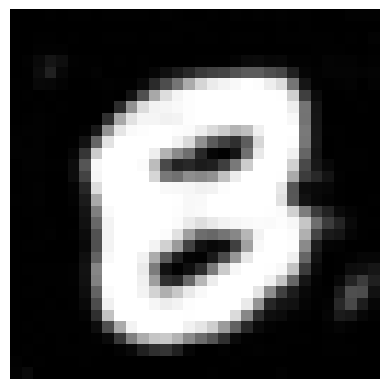

In [17]:
#@title Step 8: Show the predicted image (ok).
show_image(unet_model_2(processed_pic))